In [1]:
#Standard Imports
import geopandas as gpd
from tqdm import tqdm
import random
#import libpysal as lp
import json
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import gerrychain as gc
import numpy as np
#GerryChain Imports   #"import gerrychain as gc" to import the entire package
from gerrychain import (
    Election,
    Graph,
    MarkovChain, #importing things from the Gerrychain package
    Partition,
    accept,
    constraints,
    updaters,
)
from gerrychain.metrics import efficiency_gap, mean_median
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.updaters import cut_edges 
from gerrychain.tree import recursive_tree_part, bipartition_tree_random
from functools import partial
#Above are just the syntax for importing those parameters


In [2]:
#Load in processed schools data
schools_processed = gpd.read_file('data/new_Schools_2017_2018.json', driver='GeoJSON')


In [3]:
#Load in processed spa data
spas_processed = gpd.read_file('data/new_SPAs_2017_2018.json', driver='GeoJSON')

In [4]:
#SPA columns
spas_processed.iloc[0]

OBJECTID                                                     1
COUNT_                                                       5
SPA                                                     WL03.4
ELEM_                                                      126
INT_                                                       205
                                   ...                        
TOT_POP_B                                                    2
TOT_POP_H                                                    7
TOT_POP_N                                                    0
TOT_POP_P                                                    0
geometry     POLYGON ((11725868.08642839 7152149.053798078,...
Name: 0, Length: 75, dtype: object

In [5]:
#List of MID schools

schools_processed[schools_processed["MID_"]!=0]

,OBJECTID,SCH_CODE,CLASS,SCH_NUM,NAME,DATE_OPENE,BUILDING_D,CLASSROOMS,SPECIAL_SI,TRAILERS,...,ELEM_,INT_,MID_,HIGH_,CAPACITY,PERM_CLRM,PORT_CLRM,SPA,SCHOOL_TYP,geometry
10,11,RBM,MIDDLE,208,RIVER BEND MS,2002,0,63,8,0,...,0,0,208,0,1216,63,0,EL03,MS,POINT (11795742.945 7068417.711)
12,13,SRM,MIDDLE,209,SENECA RIDGE MS,1977,0,70,4,0,...,0,0,209,0,1264,70,0,EL27,MS,POINT (11803055.580 7059496.639)
13,14,JLS,MIDDLE,210,J LUPTON SIMPSON MS,1976,0,70,2,0,...,0,0,210,0,1255,70,0,CL37,MS,POINT (11746869.610 7081464.679)
14,15,BAM,MIDDLE,216,BRAMBLETON MS,2017,75,75,0,0,...,0,0,216,0,1269,75,0,DN36.3,MS,POINT (11752419.416 7041375.769)
24,25,BRM,MIDDLE,202,BLUE RIDGE MS,1971,0,64,5,0,...,0,0,202,0,1187,64,0,WL30,MS,POINT (11707787.222 7094850.021)
26,27,BEM,MIDDLE,201,BELMONT RIDGE MS,2003,0,60,14,0,...,0,0,201,0,1242,60,0,DN01.4,MS,POINT (11769448.876 7081692.730)
28,29,MMS,MIDDLE,207,MERCER MS,2004,0,74,2,0,...,0,0,207,0,1388,74,0,DS17,MS,POINT (11754067.400 7021436.401)
40,41,HPM,MIDDLE,206,HARPER PARK MS,1999,0,62,8,0,...,0,0,206,0,1197,62,0,CL15.3,MS,POINT (11760302.724 7083213.683)
44,45,ERM,MIDDLE,203,EAGLE RIDGE MS,2001,0,60,14,0,...,0,0,203,0,1260,60,0,DN32.3,MS,POINT (11762520.169 7054333.740)
57,58,FWS,MIDDLE,204,FARMWELL STATION MS,1995,0,59,14,2,...,0,0,204,0,1241,59,2,DN17.1,MS,POINT (11774699.744 7062320.886)


In [6]:
#Build corresponding dual graph
graph = gc.Graph.from_geodataframe(spas_processed)

C:\Users\james\Anaconda3\lib\site-packages\gerrychain\graph\adjacency.py:68: UserWarning: Found overlaps among the given polygons. Indices of overlaps: {(322, 423), (383, 389), (49, 227), (94, 95), (196, 409), (70, 209), (177, 178), (272, 273), (433, 434), (64, 180), (226, 338), (332, 333), (47, 53), (303, 444), (38, 180), (18, 265), (0, 4), (303, 304), (19, 21), (50, 407), (52, 301), (212, 236), (98, 339), (277, 315), (233, 234), (196, 212), (427, 428), (13, 56), (199, 236), (241, 416), (95, 378), (145, 291), (21, 299), (266, 285), (71, 72), (176, 178), (30, 187), (84, 247), (6, 445), (278, 397), (316, 395), (13, 231), (242, 424), (20, 303), (141, 288), (83, 181), (20, 87), (51, 147), (65, 119), (279, 381), (328, 330), (345, 346), (403, 409), (244, 361), (7, 10), (214, 358), (30, 275), (277, 294), (103, 430), (332, 334), (87, 444), (196, 292), (332, 345), (345, 358), (265, 266), (393, 394), (357, 437), (234, 252), (99, 293), (277, 314), (149, 150), (75, 287), (0, 13), (51, 408), (408,

In [7]:
#Add centroids to graph for plotting purposes
centroids = spas_processed.centroid
spas_processed["C_X"] = centroids.x
spas_processed["C_Y"] = centroids.y


graph.add_data(spas_processed)

In [8]:
#Dual graph contents
graph.nodes[0]


{'boundary_node': True,
 'boundary_perim': 205.30322108969995,
 'area': 63993687.70828096,
 'OBJECTID': 1,
 'COUNT_': 5.0,
 'SPA': 'WL03.4',
 'ELEM_': 126,
 'INT_': 205,
 'HIGH_': 311,
 'ELEM_CODE': 'LOV',
 'MID_CODE': 'HRM',
 'HIGH_CODE': 'WHS',
 'DISTRICT': 'WL',
 'UTILITIES': 'WOU',
 'SHAPE_Leng': 47268.7885828,
 'SHAPE_Area': 63993837.1512,
 'STDYAREA_1': 'WL03.4',
 'DISTRICT_1': 'WL',
 'PLANNING_Z': 'WL03.4',
 'ELEM': 'LOV',
 'MID': 'HRM',
 'HIGH': 'WHS',
 'UTILITIE_1': 'WOU',
 'DISTRICT_2': 'WL',
 'MID_2018': 'HRM',
 'HIGH_2018': 'WHS',
 'PK': 2,
 'KG': 2,
 'GR1': 4,
 'GR2': 5,
 'GR3': 3,
 'GR4': 5,
 'GR5': 4,
 'GR6': 2,
 'GR7': 4,
 'GR8': 4,
 'GR9': 5,
 'GR10': 3,
 'GR11': 3,
 'GR12': 3,
 'TOTAL_KG_5': 23,
 'TOTAL_6_8': 10,
 'TOTAL_9_12': 14,
 'TOTAL_KG_1': 47,
 'TOTAL_PK_1': 49,
 'ELEM_POP': 23,
 'MID_POP': 10,
 'HIGH_POP': 14,
 'TOT_POP': 47,
 'ELEM_POP_A': 0,
 'ELEM_POP_W': 17,
 'ELEM_POP_M2': 0,
 'ELEM_POP_B': 2,
 'ELEM_POP_H': 4,
 'ELEM_POP_N': 0,
 'ELEM_POP_P': 0,
 'MID_PO

In [9]:
#Add nonWhite column for evaluation
for node in graph.nodes(): 
    graph.nodes[node]["MID_POP_nW"] = graph.nodes[node]["MID_POP"] - graph.nodes[node]["MID_POP_W"]

In [10]:
spas_processed["MID_CODE"].unique()


array(['HRM', 'BRM', 'SMM', 'HPM', 'JLS', 'JML', 'MMS', 'SRM', 'RBM',
       'STM', 'BAM', 'BEM', 'SHM', 'FWS', 'TMS', 'ERM'], dtype=object)

C:\Users\james\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


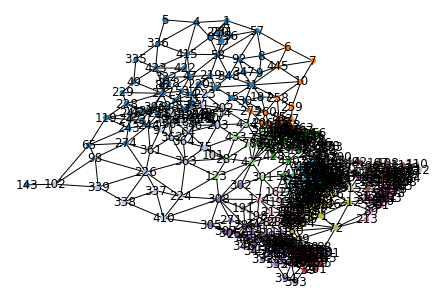

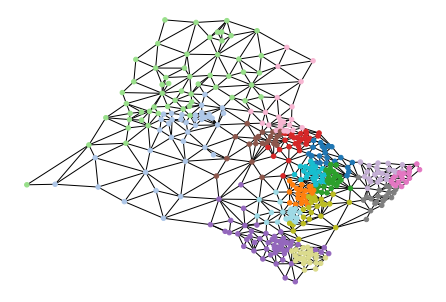

In [11]:
#Plot dual graph and current school districts
%matplotlib notebook 
%matplotlib inline
color_dict = dict()
i = 1
for code in spas_processed["MID_CODE"].unique():
    color_dict[code] = i
    i = i+1


nx.draw(graph, pos ={n:(graph.nodes[n]['C_X'],graph.nodes[n]['C_Y']) for n in graph.nodes()},node_size=20,node_color = [color_dict[graph.nodes[node]["MID_2018"]] for node in graph.nodes()],cmap='tab20',with_labels=True)
plt.show()
%matplotlib notebook
graph.add_edge(143,65)
nx.draw(graph, pos ={n:(graph.nodes[n]['C_X'],graph.nodes[n]['C_Y']) for n in graph.nodes()},node_size=20,node_color = [graph.nodes[node]["INT_"] for node in graph.nodes()],cmap='tab20')
plt.show()

In [12]:
#Node 392 is unoccupied but also discontiguous
graph.nodes[392]["MID_CODE"] = "STM"

In [13]:
#Experimental
graph.nodes[392]

{'boundary_node': False,
 'area': 19749549.455430534,
 'OBJECTID': 395,
 'COUNT_': 4.0,
 'SPA': 'EL36.1',
 'ELEM_': 138,
 'INT_': 212,
 'HIGH_': 306,
 'ELEM_CODE': 'STE',
 'MID_CODE': 'STM',
 'HIGH_CODE': 'PVH',
 'DISTRICT': 'EL',
 'UTILITIES': 'WU',
 'SHAPE_Leng': 25868.2281063,
 'SHAPE_Area': 19749549.4554,
 'STDYAREA_1': 'EL36.1',
 'DISTRICT_1': 'EL',
 'PLANNING_Z': 'EL36.1',
 'ELEM': 'STE',
 'MID': 'STM',
 'HIGH': 'PVH',
 'UTILITIE_1': 'WU',
 'DISTRICT_2': 'EL',
 'MID_2018': 'STM',
 'HIGH_2018': 'PVH',
 'PK': 0,
 'KG': 0,
 'GR1': 0,
 'GR2': 0,
 'GR3': 0,
 'GR4': 0,
 'GR5': 0,
 'GR6': 0,
 'GR7': 0,
 'GR8': 0,
 'GR9': 0,
 'GR10': 0,
 'GR11': 0,
 'GR12': 0,
 'TOTAL_KG_5': 0,
 'TOTAL_6_8': 0,
 'TOTAL_9_12': 0,
 'TOTAL_KG_1': 0,
 'TOTAL_PK_1': 0,
 'ELEM_POP': 0,
 'MID_POP': 0,
 'HIGH_POP': 0,
 'TOT_POP': 0,
 'ELEM_POP_A': 0,
 'ELEM_POP_W': 0,
 'ELEM_POP_M2': 0,
 'ELEM_POP_B': 0,
 'ELEM_POP_H': 0,
 'ELEM_POP_N': 0,
 'ELEM_POP_P': 0,
 'MID_POP_A': 0,
 'MID_POP_W': 0,
 'MID_POP_M2': 0,
 'M

### Uncommented and commented this part out for contiguity

In [14]:
#Troubleshooting contiguity
# for part in current_districts.parts:
#     sgraph = nx.subgraph(graph,current_districts.parts[part])
#     print(part)
#     nx.draw(sgraph, pos ={n:(sgraph.nodes[n]['C_X'],sgraph.nodes[n]['C_Y']) for n in sgraph.nodes()},node_size=20,node_color = [sgraph.nodes[node]["INT_"] for node in sgraph.nodes()],cmap='tab20')
#     plt.show()


In [15]:
#Setup helper functions to measure which school in which spa and what capacities are
school_container = {}
for index, row in schools_processed.iterrows():
    for node in graph.nodes(): 
        if row["SPA"] == graph.nodes[node]["STDYAREA_1"]:
            school_container[row["SCH_CODE"]] = node

school_capacities = {}

for index, row in schools_processed.iterrows():
    school_capacities[row["SCH_CODE"]] = row["CAPACITY"]
    
school_container['HRM']
print(sorted(list(school_container.values())))


[7, 11, 18, 18, 24, 26, 26, 26, 38, 50, 52, 60, 60, 61, 63, 64, 82, 85, 85, 85, 87, 91, 94, 94, 95, 96, 103, 107, 107, 108, 112, 117, 126, 127, 127, 135, 136, 142, 145, 150, 161, 176, 181, 181, 181, 182, 183, 183, 185, 197, 199, 205, 207, 207, 208, 208, 208, 215, 231, 245, 246, 246, 248, 256, 262, 264, 264, 273, 276, 296, 296, 299, 300, 301, 303, 303, 305, 310, 310, 316, 320, 322, 338, 343, 345, 345, 356, 359, 373, 374, 386, 398, 398, 401, 402, 403, 410, 410, 418, 420, 424, 425, 426, 429, 438]


In [16]:
#function for tracking overloads and setup updaters
def overload_tracker(partition):
    overloads = dict()
    for part in partition.parts.keys():
        overloads[part] = partition['population'][part] - school_capacities[part]
    return overloads

#positive bad negative good    

updater = { #an updater is basically what your interested in measuring
        "population": updaters.Tally("MID_POP", alias="population"),
    "A": updaters.Tally("MID_POP_A", alias="population"),
    "W": updaters.Tally("MID_POP_W", alias="population"),
    "M2": updaters.Tally("MID_POP_M2", alias="population"),
    "B": updaters.Tally("MID_POP_B", alias="population"),
    "H": updaters.Tally("MID_POP_H", alias="population"),
    "N": updaters.Tally("MID_POP_N", alias="population"),
    "P": updaters.Tally("MID_POP_P", alias="population"),
    "WnW": Election("WnW", {"White": "MID_POP_W", "nonWhite": "MID_POP_nW"}),
    "Overloads": overload_tracker,
    "cut_edges": cut_edges, #edges in the dual graph that are next to each other but belong in different districts.
            }


In [17]:
#Evaluate data types
current_districts = Partition(graph,"MID_CODE",updater)
current_districts["WnW"].percents("White")

(0.8254716981132075,
 0.789247311827957,
 0.525243578387954,
 0.5408631772268135,
 0.6054613935969868,
 0.469981807155852,
 0.39413333333333334,
 0.4612202688728025,
 0.47163695299837927,
 0.15080113100848255,
 0.4807355516637478,
 0.5524475524475524,
 0.22799575821845175,
 0.4666073018699911,
 0.5906480721903199,
 0.5131987577639752)

In [18]:
#Check initial district overloads
print(current_districts["Overloads"])
sum(current_districts["Overloads"].values())

{'HRM': -164, 'BRM': -257, 'SMM': -86, 'HPM': -108, 'JLS': -193, 'JML': 197, 'MMS': 487, 'SRM': -297, 'RBM': 18, 'STM': -108, 'BAM': -127, 'BEM': 45, 'SHM': -396, 'FWS': -118, 'TMS': -50, 'ERM': 28}


-1129

In [19]:
#Format of current districts
current_districts.parts

{'HRM': frozenset({0,
            1,
            3,
            4,
            5,
            8,
            9,
            11,
            12,
            13,
            14,
            15,
            30,
            32,
            33,
            47,
            49,
            53,
            54,
            56,
            57,
            58,
            65,
            83,
            86,
            92,
            119,
            143,
            181,
            187,
            218,
            219,
            220,
            227,
            228,
            229,
            230,
            231,
            232,
            242,
            243,
            244,
            245,
            274,
            322,
            335,
            336,
            347,
            348,
            396,
            398,
            399,
            415,
            422,
            423,
            424}),
 'BRM': frozenset({2,
            25,
            31,
            34,
  

In [20]:
#helper functions for measuring acceptance into Markov chain
def contains(partition):
    
    #assign = dict(partition.assignment)
    
    for part in partition.parts.keys():
        if school_container[part] not in partition.parts[part]:
            return False
    
    return True

def capacities(partition):
    for part in partition.parts.keys():
        if partition["population"][part] > 500+school_capacities[part]:
            #print(part)
            return False
    return True
        
        
    #changed 300 to 500    

In [21]:
#Each district contains exactly 1 school building
contains(current_districts)

True

In [22]:
#All capacities are within 300 pupils of their limits
capacities(current_districts)

True

In [23]:
#checking outliers
# school_capacities["?"]

In [24]:
#current student assignment numbers
current_districts['population']

{'HRM': 1060,
 'BRM': 930,
 'SMM': 1129,
 'HPM': 1089,
 'JLS': 1062,
 'JML': 1649,
 'MMS': 1875,
 'SRM': 967,
 'RBM': 1234,
 'STM': 1061,
 'BAM': 1142,
 'BEM': 1287,
 'SHM': 943,
 'FWS': 1123,
 'TMS': 1219,
 'ERM': 1288}

In [25]:
#school data row - checking capacity
schools_processed[schools_processed["SCH_CODE"]=="BRM"]

,OBJECTID,SCH_CODE,CLASS,SCH_NUM,NAME,DATE_OPENE,BUILDING_D,CLASSROOMS,SPECIAL_SI,TRAILERS,...,ELEM_,INT_,MID_,HIGH_,CAPACITY,PERM_CLRM,PORT_CLRM,SPA,SCHOOL_TYP,geometry
24,25,BRM,MIDDLE,202,BLUE RIDGE MS,1971,0,64,5,0,...,0,0,202,0,1187,64,0,WL30,MS,POINT (11707787.222 7094850.021)


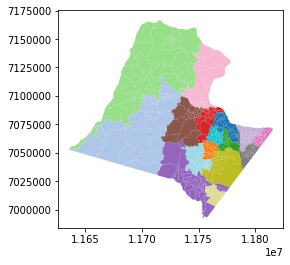

In [26]:
#plot of current districts
spas_processed.plot(column="INT_",cmap='tab20')

In [27]:
#checking contiguity of plan
constraints.single_flip_contiguous(current_districts)

False

In [28]:
#simple compactness bound to compare to initial map
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 1.1*len(current_districts["cut_edges"])
)


In [29]:
#Sample acceptance function to attempt to balance school populations
def overload_balancing(partition):

    if abs(sum(partition["Overloads"].values())) <= abs(sum(partition.parent["Overloads"].values())):
        return True
    else:
        if random.random() < .1:
            return True
        else:
            return False
        
def overload_decrease(partition):

    if abs(sum([x for x in partition["Overloads"].values() if x > 0])) <= abs(sum([x for x in partition.parent["Overloads"].values() if x > 0])):
        return True
    else:
        if random.random() < .1:
            return True
        else:
            return False        


In [30]:
#formulate recom proposal
ideal_population = sum(current_districts["population"].values()) / len(current_districts)

tree_proposal = partial(
    recom,
    pop_col="MID_POP",
    pop_target=ideal_population,
    epsilon=0.1,
    node_repeats=1,
)


In [31]:
#initialize different Markov chains
recom_chain = MarkovChain(
    tree_proposal,
    constraints.Validator([
#         constraints.single_flip_contiguous,
                           contains,
                           capacities]),
    accept=accept.always_accept,
    initial_state=current_districts,
    total_steps=500,
)

flip_chain = MarkovChain(
    propose_random_flip,
    constraints.Validator([
#         constraints.single_flip_contiguous, 
        contains,
        capacities]),
    accept=overload_balancing,#accept.always_accept,
    initial_state=current_districts,
    total_steps=10000,
)

b_flip_chain = MarkovChain(
    propose_random_flip,
    constraints.Validator([
    #   constraints.single_flip_contiguous, 
        contains,
        capacities,
        compactness_bound]),
    accept=overload_decrease,#accept.always_accept,
    initial_state=current_districts,
    total_steps=10000,
)



### Temporary fix on contiguity, so I commented constraints.single_flip_contiguous out since it was giving me false when run

In [32]:
# ethnic variable definitions
grade = 'MID'
asians = '{}_POP_A'.format(grade)
whites = '{}_POP_W'.format(grade)
mixed = '{}_POP_M2'.format(grade)
blacks = '{}_POP_B'.format(grade)
hispanics = '{}_POP_H'.format(grade)
natives = '{}_POP_N'.format(grade)
pacifics = '{}_POP_P'.format(grade)
non_whites = '{}_POP_NW'.format(grade)

# helper function
def group_processed_df(spas, grouping_column):
    spas_ethnic = spas[[grouping_column , asians, whites, mixed, blacks, hispanics, natives, pacifics, '{}_POP'.format(grade)]]
    spas_ethnic.loc[:, non_whites] = spas_ethnic.loc[:, asians] +  spas_ethnic.loc[:,blacks] +  spas_ethnic.loc[:,mixed] \
                                + spas_ethnic.loc[:,hispanics] + spas_ethnic.loc[:,natives] + spas_ethnic.loc[:,pacifics]
    spas_grouped_raw = spas_ethnic.groupby([grouping_column ]).sum()
    spas_grouped = spas_grouped_raw.div(spas_grouped_raw['{}_POP'.format(grade)], axis=0)
    spas_grouped.drop([asians, mixed, blacks, hispanics, natives, pacifics, '{}_POP'.format(grade)], axis='columns', inplace=True)
    return spas_grouped


# ETHNICITY METRIC MEASURES
def abs_diff_measurement(df):
    import itertools
    
    # group dataframe by district assignments
    df = group_processed_df(df, 'current_state')
    
    # calculate absolute differences
    abs_diffs = []
    for row in df.iterrows():
#         print([val for val in itertools.permutations(row[1], 2)])
    #     break
        diffs = [abs(val[1] - val[0]) for val in itertools.permutations(row[1], 2)]
        total = sum(diffs)/2
        abs_diffs.append(total)
    return abs_diffs
    
    
def ind_diss_measurement(df):
    # group dataframe by district assignments
    df = group_processed_df(df, 'current_state')
    
    # calculate dissimilarity index
    ind_diss = 0.5 * sum(abs(df[whites]/df[whites].sum() - df[non_whites]/df[non_whites].sum()))

    return ind_diss

def entropy_measurement(df):
    from numpy import log
    
    # group dataframe by district assignments
    df = group_processed_df(df, 'current_state')
    
    # calculate entropy index
    entropy = -(df[non_whites]*log(df[non_whites]) + df[whites]*log(df[whites]))
    entropy.replace(float('NaN'),0, inplace=True)

    return entropy

In [33]:
#Run flip chain
segregation_values = []
fW = []
for fpart in flip_chain:
    fW.append(sorted(fpart["WnW"].percents("White")))
    spas_processed['current_state'] = spas_processed.index.map(dict(fpart.assignment))
    segregation_values.append(ind_diss_measurement(spas_processed))

C:\Users\james\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\james\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [34]:
segregation_values
# sum(segregation_values)/len(segregation_values)
#found the average

[0.22744901692196107,
 0.227282108237996,
 0.228978357138417,
 0.2290972661959954,
 0.22945138527281123,
 0.22642904941704636,
 0.22631921679403838,
 0.22751792919633376,
 0.22728343396004644,
 0.22241580528766794,
 0.22187962074289144,
 0.22081896227057515,
 0.21965501180661598,
 0.22048118870319433,
 0.2128500432968735,
 0.21093454409969925,
 0.2090626143093669,
 0.20912156019592523,
 0.2092357299992959,
 0.20744859987366765,
 0.20745898423559636,
 0.20783142730198137,
 0.20761703535978387,
 0.20761703535978387,
 0.2079276439687806,
 0.2079276439687806,
 0.20781477230101564,
 0.207984415511815,
 0.21144525644866902,
 0.21154629336649064,
 0.2133550427895869,
 0.21112481632835514,
 0.2108172389748611,
 0.21125447653948903,
 0.21900416139381482,
 0.2189912862510904,
 0.2190502241494793,
 0.2192237274341629,
 0.21917867798181434,
 0.22375051281856675,
 0.22375051281856675,
 0.2235941543824689,
 0.2235941543824689,
 0.2201823248139844,
 0.2202786274709765,
 0.22051279463939147,
 0.220378

ValueError: x and y must have same first dimension, but have shapes (15,) and (16,)

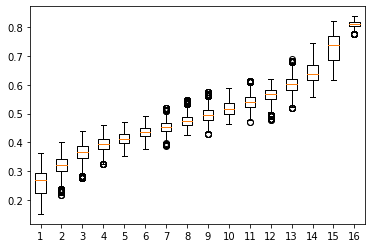

In [35]:
#Plot White percentage across ensemble
fW = np.array(fW)
plt.boxplot(fW)
plt.plot([x for x in range(1,16)],sorted(current_districts["WnW"].percents("White")),'o',color='r')

In [ ]:
#plot final districts
%matplotlib inline 

cdistrict = dict(fpart.assignment)
nx.draw(graph, pos ={n:(graph.nodes[n]['C_X'],graph.nodes[n]['C_Y']) for n in graph.nodes()},node_size=20,node_color = [color_dict[graph.nodes[node]["MID_2018"]] for node in graph.nodes()],cmap='tab20')
plt.show()

nx.draw(graph, pos ={n:(graph.nodes[n]['C_X'],graph.nodes[n]['C_Y']) for n in graph.nodes()},node_size=20,node_color = [color_dict[cdistrict[node]] for node in graph.nodes()],cmap='tab20')
plt.show()

spas_processed['partition'] = spas_processed.index.map(cdistrict)

spas_processed.plot(column='MID_2018',cmap='tab20')

spas_processed.plot(column='partition',cmap='tab20')

In [ ]:
#run flip chain with compactness boudns
b_fW = []
for bfpart in b_flip_chain:
    b_fW.append(sorted(bfpart["WnW"].percents("White")))
    


In [ ]:
#plot white percentage across ensemble
b_fW = np.array(b_fW)
plt.boxplot(b_fW)
plt.plot([x for x in range(1,16)],sorted(current_districts["WnW"].percents("White")),'o',color='r')

In [ ]:
#plot final plan
%matplotlib inline 

cdistrict = dict(bfpart.assignment)
nx.draw(graph, pos ={n:(graph.nodes[n]['C_X'],graph.nodes[n]['C_Y']) for n in graph.nodes()},node_size=20,node_color = [color_dict[graph.nodes[node]["MID_2018"]] for node in graph.nodes()],cmap='tab20')
plt.show()

nx.draw(graph, pos ={n:(graph.nodes[n]['C_X'],graph.nodes[n]['C_Y']) for n in graph.nodes()},node_size=20,node_color = [color_dict[cdistrict[node]] for node in graph.nodes()],cmap='tab20')
plt.show()

spas_processed['partition'] = spas_processed.index.map(cdistrict)

spas_processed.plot(column='MID_2018',cmap='tab20')

spas_processed.plot(column='partition',cmap='tab20')

In [ ]:
#run recom chain
rW = []
for rpart in recom_chain:
    rW.append(sorted(rpart["WnW"].percents("White")))
    


In [ ]:
#plot white percentage across ensemble
rW = np.array(rW)
plt.boxplot(rW)
plt.plot([x for x in range(1,16)],sorted(current_districts["WnW"].percents("White")),'o',color='r')

In [ ]:
#plot final plan
cdistrict = dict(rpart.assignment)

nx.draw(graph, pos ={n:(graph.nodes[n]['C_X'],graph.nodes[n]['C_Y']) for n in graph.nodes()},node_size=20,node_color = [color_dict[graph.nodes[node]["MID_2018"]] for node in graph.nodes()],cmap='tab20')
plt.show()

nx.draw(graph, pos ={n:(graph.nodes[n]['C_X'],graph.nodes[n]['C_Y']) for n in graph.nodes()},node_size=20,node_color = [color_dict[cdistrict[node]] for node in graph.nodes()],cmap='tab20')
plt.show()

spas_processed['partition'] = spas_processed.index.map(cdistrict)

spas_processed.plot(column='MID_2018',cmap='tab20')

spas_processed.plot(column='partition',cmap='tab20')